# Experiment 6: Generalize Experiment 02: Study performance stability over time
This generalizes and extends Experiment 02, by adding XGBoost (in addition to the Naive Bayes model).  

We only add XGBoost here, in addition to Naive Bayes,  because that outperformed other models like Random Forest and Isolation Forest in Experiment 05.  We only study QM features which outperformed CL features. We only include 1f features because in experiment 05 they performed the same as 3f features for XGBoost, and are simpler.

In this notebook, we train a model before a cutoff date, then test after the cutoff date, to assess performance stability over time.

In [12]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import sys
import subprocess
import random
import pickle
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# from tqdm.autonotebook import tqdm
from tqdm.notebook import tqdm

import uncertainties

from image_compression_attribution.common.code.models import quant_matrices, compr_levels
from image_compression_attribution.common.code.summarize_quant_matrices import summarize_compression_features

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

from sklearn.metrics import make_scorer, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#WARNING: this method does not seem to work well when there are large gaps
#in the ROC curve. Hence, only use this if you have interpolated between
#ROC curve data points to fill in the roc curve on a grid with small intervals.
#https://github.com/scikit-learn/scikit-learn/issues/15247#issuecomment-542138349
def calculate_eer(fpr, tpr):
    '''
    Returns the equal error rate for a binary classifier output.
    '''
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer
  
#---------------------------------------------------------------
#Code to combine mean value and uncertainty estimate into
#one formatted string, like 3.14 +/- .02 becomes "3.14(2)"

import string

class ShorthandFormatter(string.Formatter):
  """https://pythonhosted.org/uncertainties/user_guide.html"""

  def format_field(self, value, format_spec):
    if isinstance(value, uncertainties.UFloat):
      return value.format(format_spec+'S')  # Shorthand option added
    # Special formatting for other types can be added here (floats, etc.)
    else:
      # Usual formatting:
      return super(ShorthandFormatter, self).format_field(
        value, format_spec)

def uncertainty_format_arrays(mean_vals, uncertainty_vals):
  frmtr_uncertainty = ShorthandFormatter()
  
  vals_formatted = []
  for mean, uncert in zip(mean_vals, uncertainty_vals):
    number = uncertainties.ufloat(mean, uncert)
    str_formatted = frmtr_uncertainty.format("{0:.1u}", number)
    vals_formatted.append(str_formatted)
  return vals_formatted

In [14]:
RND_SEED=1234
np.random.seed(RND_SEED)

In [15]:
SUMMARY_FILE = "/app/dataset/data.csv"

RESULTS_FOLDER = "results/exp_06"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

df = pd.read_csv(SUMMARY_FILE)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

#Drop non-image files, e.g. html files returned
#due to download errors

df, df_dropped = df[ df['mime'].str.startswith('image') ].reset_index(drop=True), \
  df[ ~df['mime'].str.startswith('image') ].reset_index(drop=True)

sources = sorted(list(df['source'].unique()))


In [16]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
#Guide to LabelEncoder:  
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


#create numerical class labels for quantization categorical names (suitable for 
#use as  ML training feature vector)
le_qs = preprocessing.LabelEncoder()
le_qs.fit(df['q_name'])
df['q_name_class'] = le_qs.transform(df['q_name'])

sources = sorted(list(df['source'].unique()))
le_sources = preprocessing.LabelEncoder()
le_sources.fit(sources)
df['source_class'] = le_sources.transform(df['source'])

In [17]:
df

,articleUrl,articleHash,imageUrl,source,mime,compression,q_hash,q_name,timestamp,q_name_class,source_class
0,https://www.abc.net.au/news/2020-05-25/toowoomba-unemployment-hits-horrific-level/12282346,4de7b04b17622bc838468486216f9878,https://live-production.wcms.abc-cdn.net.au/10d55dfa1fef3ec5f4f20cdac0b64df5?impolicy=wcms_crop_resize&cropH=528&cropW=938&xPos=1&yPos=0&width=862&height=485,abc.net.au,image/webp,92,NaN,webp_092,2020-05-25 00:00:00+00:00,254,0
1,https://www.abc.net.au/news/2017-01-11/trade-war-between-us-and-china-a-major-threat-to-australia/8172562,99770eadd0f12e1c63df525a8c739f8c,https://live-production.wcms.abc-cdn.net.au/bcbaa4880d63e1b7c46ac95773583381?impolicy=wcms_crop_resize&cropH=1037&cropW=1851&xPos=0&yPos=0&width=862&height=485,abc.net.au,image/webp,92,NaN,webp_092,2017-01-11 00:00:00+00:00,254,0
2,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/28314158cc17db94d2062a7539d49fd9?impolicy=wcms_crop_resize&cropH=1515&cropW=2272&xPos=0&yPos=0&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
3,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/be7013fd935ad10ecd612700c2973c9b?impolicy=wcms_crop_resize&cropH=2250&cropW=2250&xPos=375&yPos=0&width=862&height=862,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
4,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/b639a168ddb98a55e2c46628278f6063?impolicy=wcms_crop_resize&cropH=2001&cropW=3000&xPos=0&yPos=0&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
...,...,...,...,...,...,...,...,...,...,...,...
64680,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/DC772857-F881-4A9E-B36A-B693023E9514.jpg,voanews,image/jpeg,50,48c9be01d998be93be725587386b3028,jpeg_050_48c9b,2016-09-15 18:20:00+00:00,13,29
64681,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced_737px_wide/s3/2019-04/48F9FC10-1A1C-4D52-949E-93D7CA7AEF2A.png?itok=DnRzA_-G,voanews,image/webp,92,NaN,webp_092,2016-09-15 18:20:00+00:00,254,29
64682,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced_737px_wide/s3/2019-04/48F9FC10-1A1C-4D52-949E-93D7CA7AEF2A.png,voanews,image/webp,92,NaN,webp_092,2016-09-15 18:20:00+00:00,254,29
64683,https://www.voanews.com/usa/text-trump-kim-summit-agreement,a211274edc80df58940fa8d981593dcede819f348f3056f247303b03019f20b0,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/42E315BD-BBDD-4C79-BB40-387CAB29E6AB.jpg?itok=xnZSXjXB,voanews,image/jpeg,50,48c9be01d998be93be725587386b3028,jpeg_050_48c9b,2018-06-12 04:55:00+00:00,13,29


In [18]:
df.groupby('source')['timestamp'].min()

source
abc.net.au             2003-11-06 00:00:00+00:00
airforcetimes.com      2014-07-21 00:00:00+00:00
aljazeera              2003-08-10 00:00:00+00:00
allafrica.com          2016-03-17 00:00:00+00:00
americanfreepress      2011-08-09 00:00:00+00:00
asahi.com              2020-05-20 07:00:00+00:00
bbc                    2010-07-14 16:39:08+00:00
canadiandimension      2003-11-01 00:00:00+00:00
ceasefire              2008-05-29 00:00:00+00:00
centurywire            2011-08-07 18:20:28+00:00
egypttoday             2012-01-12 12:17:00+00:00
france24               2007-06-22 05:49:00+00:00
ghanaiantimes.com.gh   2019-02-22 00:00:00+00:00
globaltimes            2019-10-01 00:00:00+00:00
hindustantimes.com     2016-07-01 01:28:00+00:00
japantimes.co.jp       2009-10-11 00:00:00+00:00
koreatimes.co.kr       2007-04-01 00:00:00+00:00
militarytimes.com      2014-08-27 00:00:00+00:00
navytimes.com          2014-11-03 00:00:00+00:00
nst                    2015-09-03 00:00:00+00:00
oneindia.com 

In [19]:
df.groupby('source')['timestamp'].max()

source
abc.net.au             2021-04-14 00:00:00+00:00
airforcetimes.com      2021-04-08 00:00:00+00:00
aljazeera              2021-01-08 00:00:00+00:00
allafrica.com          2021-04-08 00:00:00+00:00
americanfreepress      2020-09-16 00:00:00+00:00
asahi.com              2021-04-08 17:30:00+00:00
bbc                    2021-01-11 11:45:07+00:00
canadiandimension      2020-12-18 00:00:00+00:00
ceasefire              2021-01-10 00:00:00+00:00
centurywire            2020-09-16 12:03:46+00:00
egypttoday             2021-01-13 08:18:00+00:00
france24               2021-01-09 02:51:49+00:00
ghanaiantimes.com.gh   2021-04-08 00:00:00+00:00
globaltimes            2021-05-01 00:00:00+00:00
hindustantimes.com     2021-04-08 21:08:00+00:00
japantimes.co.jp       2021-04-09 00:00:00+00:00
koreatimes.co.kr       2021-04-01 00:00:00+00:00
militarytimes.com      2021-04-08 00:00:00+00:00
navytimes.com          2021-04-08 00:00:00+00:00
nst                    2021-06-03 00:00:00+00:00
oneindia.com 

In [20]:
timespan = df.groupby('source')['timestamp'].max() - df.groupby('source')['timestamp'].min()
timespan_list = timespan.tolist()

timespan_list2 = [(x.days + x.seconds/86400.0)/365.2425 for x in timespan_list]
timespan_years = pd.Series(timespan_list2, index=sources)

print("mean timespan = {:.1f} years".format(timespan_years.mean()))
with open(os.path.join(RESULTS_FOLDER,"timespan_years_mean.txt"),"w") as file1:
  file1.write("{:.1f}".format(timespan_years.mean()))

print("min timespan = {:.2f} years".format(timespan_years.min()))
with open(os.path.join(RESULTS_FOLDER,"timespan_years_min.txt"),"w") as file1:
  file1.write("{:.2f}".format(timespan_years.min()))

print("max timespan = {:.1f} years".format(timespan_years.max()))
with open(os.path.join(RESULTS_FOLDER,"timespan_years_max.txt"),"w") as file1:
  file1.write("{:.1f}".format(timespan_years.max()))

timespan_years

mean timespan = 10.1 years
min timespan = 0.89 years
max timespan = 21.4 years


abc.net.au              17.437730
airforcetimes.com        6.716086
aljazeera               17.415826
allafrica.com            5.059652
americanfreepress        9.106279
asahi.com                0.885542
bbc                     10.496576
canadiandimension       17.131084
ceasefire               12.619013
centurywire              9.111038
egypttoday               9.004522
france24                13.552303
ghanaiantimes.com.gh     2.124616
globaltimes              1.582510
hindustantimes.com       4.771678
japantimes.co.jp        11.493734
koreatimes.co.kr        14.001656
militarytimes.com        6.614783
navytimes.com            6.428606
nst                      5.749605
oneindia.com            10.609545
rferl                   15.118240
russiatoday             11.918678
sbs.com.au               7.761733
straitstimes             5.552651
taipeitimes             21.358413
thestar.com             18.469921
timesofindia            15.320478
trtworld                 4.793542
voanews       

## Method:
Note: date ranges of sources may not overlap. So instead of picking 1 cutoff date, effectivley have a separate cutoff date for each source, to split each source into two halfs. Put antother way, sort articles from each source, and within a source, split the articles into two halfs: before and after the date midpoint.
1. All articles (from each source) from before the cutoff date form the train set -- first 60% of articles.
1. Then form the test set:
    1. Select all articles from a source after the cutoff date -- last 40% of articles.
    1. Randomly sample an equal number of articles from the remaining sources, also after each's cutoff date.
    1. Combine them to form the test set.
1. Since composition of test set varies, repeat 5x.

First do some precomputation: For each source, sort the articles by date, then split articles from each source into an early portion and later portion. Early portions can be used for training, later portions can be used for testing.

In [21]:
PERCENT_TEST = 0.40

df_articles = df[['articleHash', 'timestamp', 'source', 'source_class']].drop_duplicates()

articles_predate = {}
articles_postdate = {}

for source in sources:
  # source = sources[0]

  #get all articles from the source, sorted by date
  df_articles_from_source = df_articles[df_articles['source']==source].sort_values(by="timestamp")

  num_test_articles_from_source = int(PERCENT_TEST*len(df_articles_from_source))
  num_train_articles_from_source = len(df_articles_from_source) - num_test_articles_from_source

  df_art_from_source_predate = df_articles_from_source.iloc[0:num_train_articles_from_source,:]
  df_art_from_source_postdate = df_articles_from_source.iloc[num_train_articles_from_source:,:]

  articles_predate[source] = df_art_from_source_predate
  articles_postdate[source] = df_art_from_source_postdate

In [22]:
import xgboost as xgb

In [ ]:
#Prepare Train and Test Split.

all_q_name_vals = sorted(df['q_name'].unique())

#Sample from articles (so we can keep images from articles grouped together)
df_articles = df[['articleHash', 'timestamp', 'source', 'source_class']].drop_duplicates()

NUM_TRIALS = 5
results_per_trial_qm = {}
results_per_trial_xgb = {}

for trial in tqdm(range(NUM_TRIALS)):
  #trial = 0

  numsamples_balanced_testset=[]
  AUCs_qm = []
  results_qm={}
  AUCs_xgb = []
  results_xgb={}

  for source in sources:
    #source = sources[0]

    remaining_sources = [s for s in sources if s != source]

    #-----------------------------------
    #Form train/test data split. Train set first:

    #All articles (from every source) from before their cutoff date form the train set
    df_train_articles = None
    for src in sources:
      if df_train_articles is None:
        df_train_articles = articles_predate[src]
      else:
        df_train_articles = pd.concat([df_train_articles, articles_predate[src] ])

    #----------------------
    #Test set:

    #All articles from a source after its cutoff date contributes to test set:
    df_articles_test_from_source = articles_postdate[source]
    num_test_articles_from_source = len(df_articles_test_from_source)

    #-------

    #collect all articles not from remaining sources from after their cutoff dates
    df_articles_postdate_not_from_source = None
    for src in remaining_sources:
      if df_articles_postdate_not_from_source is None:
        df_articles_postdate_not_from_source = articles_postdate[src]
      else:
        df_articles_postdate_not_from_source = pd.concat([df_articles_postdate_not_from_source, articles_postdate[src] ])

    #Randomly sample an equal number of articles from the remaining sources, after their cutoff dates.
    num_test_articles_not_from_source = num_test_articles_from_source
    df_articles_test_not_from_source = df_articles_postdate_not_from_source.sample(num_test_articles_not_from_source)

    #------
    #combine to build the test set
    df_test_articles = pd.concat([df_articles_test_from_source, df_articles_test_not_from_source])

    #----------------------
    #Get all images articles in train/test splits:
    df_train = df[ df['articleHash'].isin(df_train_articles['articleHash']) ].reset_index()
    df_test = df[ df['articleHash'].isin(df_test_articles['articleHash']) ].reset_index()

    #Set ground truth label: 1 if image misattributed, else 0
    df_test['is_misattributed'] = np.array(df_test['source']!=source, dtype=int)
    df_train['is_misattributed'] = np.array(df_train['source']!=source, dtype=int)

    #-----------------------------------
    #Fit models

    #quantization matrices
    qm_model = quant_matrices.attribution_quant_matrices()
    qm_model.fit(df_train[['source', 'q_name']], compr_category_names=all_q_name_vals)
    
    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(df_train[["q_name_class"]], df_train['is_misattributed'])
    
    #-----------------------------------
    #prediction on test set
    claimed_source_list = [source]*len(df_test)

    LLRs_isfake_qm, probs_fromsource_qm, probs_notfromsource_qm, \
      unrecognized_sources_qm = qm_model.predict(df_test['q_name'], claimed_source_list)
    df_test['LLR_qm'] = LLRs_isfake_qm

    #Determine if prediction is wrong
    misclassified_qm = (df_test['is_misattributed'] - .5) * LLRs_isfake_qm < 0
    df_test['misclassified_qm'] = misclassified_qm
    
    scores = xgb_model.predict_proba(df_test[["q_name_class"]])
    df_test['scores_XGB_QM1f'] = scores[:,1]

    #-----------------------------------
    #Use hypothesis test score to compute ROC curve for this source:

    numsamples_balanced_testset.append(len(df_test))

    fpr, tpr, thresholds = roc_curve(df_test['is_misattributed'], df_test['LLR_qm'], pos_label=1)
    roc_auc = auc(fpr, tpr)
    AUCs_qm.append(roc_auc)

    results_qm[source] = {'source': source, 'fpr': fpr, 'tpr':tpr, 
                       'auc':roc_auc, 'numsamples':len(df_test),
                       'scores_isfake': df_test['LLR_qm'],
                       'label_isfake': df_test['is_misattributed'],
                       'df_test':df_test}
    results_per_trial_qm[trial] = results_qm
    #-------------
    fpr, tpr, thresholds = roc_curve(df_test['is_misattributed'], df_test['scores_XGB_QM1f'], pos_label=1)
    roc_auc = auc(fpr, tpr)
    AUCs_xgb.append(roc_auc)

    results_xgb[source] = {'source': source, 'fpr': fpr, 'tpr':tpr, 
                       'auc':roc_auc, 'numsamples':len(df_test),
                       'scores_isfake': df_test['scores_XGB_QM1f'],
                       'label_isfake': df_test['is_misattributed']}
    results_per_trial_xgb[trial] = results_xgb

## Summarize results

In [24]:
FPR_THRESHOLD = 0.005  # compute TPR @ this FPR = 0.5%

AUCs_mean_qm = []
AUCs_std_qm = []
tpr_at_fpr_mean_qm = []

AUCs_mean_xgb = []
AUCs_std_xgb = []
tpr_at_fpr_mean_xgb = []

#quantization matrices qm
for source in sources:
  AUCs_per_trial = []
  tpr_per_trial = []
  fpr_per_trial = []
  tprs_at_fpr_threshold = []
  for trial in range(NUM_TRIALS):
    AUCs_per_trial.append(results_per_trial_qm[trial][source]['auc'])
    fpr = results_per_trial_qm[trial][source]['fpr']
    tpr = results_per_trial_qm[trial][source]['tpr']
    fpr_per_trial.append(fpr)
    tpr_per_trial.append(tpr)
    tprs_at_fpr_threshold.append( np.interp(FPR_THRESHOLD, fpr, tpr) )
  AUCs_mean_qm.append(np.mean(AUCs_per_trial))
  AUCs_std_qm.append(np.std(AUCs_per_trial))
  tpr_at_fpr_mean_qm.append(np.mean(tprs_at_fpr_threshold))
  
#xgboost
for source in sources:
  AUCs_per_trial = []
  tpr_per_trial = []
  fpr_per_trial = []
  tprs_at_fpr_threshold = []
  for trial in range(NUM_TRIALS):
    AUCs_per_trial.append(results_per_trial_xgb[trial][source]['auc'])
    fpr = results_per_trial_xgb[trial][source]['fpr']
    tpr = results_per_trial_xgb[trial][source]['tpr']
    fpr_per_trial.append(fpr)
    tpr_per_trial.append(tpr)
    tprs_at_fpr_threshold.append( np.interp(FPR_THRESHOLD, fpr, tpr) )
  AUCs_mean_xgb.append(np.mean(AUCs_per_trial))
  AUCs_std_xgb.append(np.std(AUCs_per_trial))
  tpr_at_fpr_mean_xgb.append(np.mean(tprs_at_fpr_threshold))
  
df_summary = pd.DataFrame({'source':sources, 'test_size':numsamples_balanced_testset,
  'AUC_mean_qm':AUCs_mean_qm, 'AUC_std_qm':AUCs_std_qm, 
  'tpr_at_fpr_mean_qm':tpr_at_fpr_mean_qm, 
  'AUC_mean_xgb':AUCs_mean_xgb, 'AUC_std_xgb':AUCs_std_xgb, 
  'tpr_at_fpr_mean_xgb':tpr_at_fpr_mean_xgb,                           
  } )
df_summary['AUC_formatted_qm'] = uncertainty_format_arrays(df_summary['AUC_mean_qm'], df_summary['AUC_std_qm'])
df_summary['AUC_formatted_xgb'] = uncertainty_format_arrays(df_summary['AUC_mean_xgb'], df_summary['AUC_std_xgb'])

df_summary


,source,test_size,AUC_mean_qm,AUC_std_qm,tpr_at_fpr_mean_qm,AUC_mean_xgb,AUC_std_xgb,tpr_at_fpr_mean_xgb,AUC_formatted_qm,AUC_formatted_xgb
0,abc.net.au,3468,0.912931,0.008176,0.362877,0.917850,0.005404,0.417708,0.913(8),0.918(5)
1,airforcetimes.com,432,0.874130,0.016895,0.592247,0.860947,0.010926,0.022078,0.87(2),0.86(1)
2,aljazeera,2544,0.940891,0.005695,0.422508,0.938515,0.007274,0.198613,0.941(6),0.939(7)
3,allafrica.com,194,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.0(0),1.0(0)
4,americanfreepress,593,0.927321,0.028026,0.227682,0.918913,0.024491,0.023468,0.93(3),0.92(2)
5,asahi.com,581,0.958993,0.012026,0.925773,0.964963,0.013006,0.932456,0.96(1),0.96(1)
6,bbc,2460,0.929389,0.019308,0.579642,0.909389,0.017776,0.043686,0.93(2),0.91(2)
7,canadiandimension,2996,0.975462,0.003536,0.907846,0.978475,0.002536,0.913722,0.975(4),0.978(3)
8,ceasefire,2551,0.830801,0.010753,0.494320,0.834861,0.013162,0.412728,0.83(1),0.83(1)
9,centurywire,115,0.887716,0.056184,0.556270,0.924566,0.058907,0.341740,0.89(6),0.92(6)


In [26]:
df_summary['AUC_mean_qm'].mean()

0.9292114586997743

In [27]:
df_summary['AUC_mean_xgb'].mean()

0.9234456713557653

In [28]:
df_summary['tpr_at_fpr_mean_qm'].mean()

0.6577860922576995

In [29]:
df_summary['tpr_at_fpr_mean_xgb'].mean()

0.5554111565048718

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
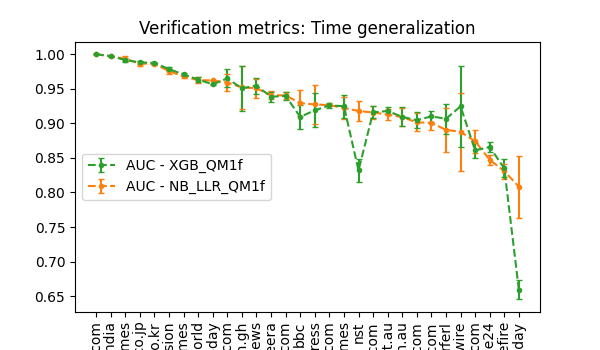

In [30]:
df_metricplot =  df_summary.sort_values(by='AUC_mean_qm', ascending=False).reset_index(drop=True)
sources_metricplot = list(df_metricplot['source'])
AUCs_metricplot_qm = list(df_metricplot['AUC_mean_qm'])
AUCs_metricplot_xgb = list(df_metricplot['AUC_mean_xgb'])

plt.figure(figsize=(6,3.5))
x_vals = [i for i,_ in enumerate(sources_metricplot)]


plt.errorbar(x_vals, AUCs_metricplot_qm, yerr=df_metricplot['AUC_std_qm'], fmt=".", linestyle="--", 
             label="AUC - NB_LLR_QM1f", color="tab:orange", mfc="tab:orange", mec='tab:orange', ecolor="tab:orange", capsize=2)

plt.errorbar(x_vals, AUCs_metricplot_xgb, yerr=df_metricplot['AUC_std_xgb'], fmt=".", linestyle="--", 
             label="AUC - XGB_QM1f", color="tab:green", mfc="tab:green", mec='tab:green', ecolor="tab:green", capsize=2)

plt.xticks(x_vals, sources_metricplot, rotation=90)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
plt.legend(handles, labels, loc="center left")

plt.title("Verification metrics: Time generalization")

# plt.tight_layout()
plt.show()
#uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"verification_metrics_plot.pdf"), bbox_inches='tight')

# Conclusions:
XGBoost slightly worse than the Naive Bayes classifier for time generalization, but performed pretty close to the same considering error bars.